# The Fourier Neural Operator method in JAX

## How does the Fourier Neural Operator method work

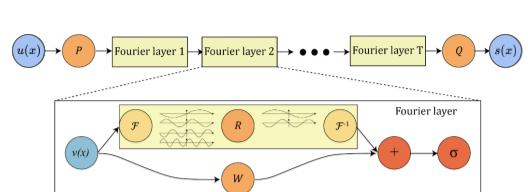

_* borrowed from Li et. al. and modified for purposes of notational consistency_

Given $\mathcal{X} ⊂ \mathbb{R}^{d_x}$, $\mathcal{Y} ⊂ \mathbb{R}^{d_y}$ we refer to $x \in \mathcal{X}$ as the input and  $y \in \mathcal{Y}$ as the query locations. We define functions $u^l \in \mathcal{C}(\mathcal{X}, \mathbb{R}^{d_u})$ the input functions and $s^l \in \mathcal{C}(\mathcal{Y}, \mathbb{R}^{d_s})$ the output functions. 

Our goal is to learn an operator $\mathcal{G}: \mathcal{C}(\mathcal{X}, \mathbb{R}^{d_u}) \to \mathcal{C}(\mathcal{Y}, \mathbb{R}^{d_s})$ using pairs of input/output functions $\{ u^l(x), s^l(y) \}_{l=1}^N$. To do that, we will consider the Fourier variant of the Neural Operator architecture. 


The Neural Operator is an iterative architecture defined as $v_0 \mapsto v_1 ↦ ... \mapsto  v_T$ for $v_j$ where $j=1,...,T-1$ transforms in $\mathbb{R}^{d_v}$ and is constructed in three parts:

1.   Applying $v_0$ to the input function lifts it to a higher dimensional representation $v_0(x) = P(u(x))$ where $P$ a local transformation, i.e. a shallow MLP. 
2.  Iteratively apply updates $v_t ↦ v_{t+1}$ for $v_j$ where $j =1, ..., T-1$.
3.  The last transformation $s(x) = Q(v_T(x))$ projects the representation back to the dimensions of the output function, using again a local transformation. 

**Let's examine how Step 2. works:**

The function in Step 2 is defined as:

$$v_{t+1} = \sigma( W v_t(x) + (\mathcal{K}(u;\phi)v_t)(x)), ∀ x \in \mathcal{X}.$$

We can choose $\mathcal{K}(u;\phi)$ to be an integral operator and get:

$$v_{t+1} = \sigma (W v_t(x) + \int_{\mathcal{X}} \kappa (x, y, u(x), u(y); \phi)v_t(x) dy, \quad ∀ x \in \mathcal{X},$$

where $\kappa_{\phi}$, a learnable kernel represented by a neural network parameterized by parameters $\phi$, $W$ a linear transformation and $\sigma$ a non-linear element-wise activation function. 


In the Fourier Neural Operator architecture, the kernel is considered to be stationary and independent of $u$, thus it can be replaced by a convolution operator defined in the Fourier space:

$$(\mathcal{K}(\phi)v_t)(x) = \mathcal{F}^{-1} (\mathcal{F}(\kappa_{\phi}) \cdot \mathcal{F}(v_t))(x)$$

where we can parameterize the Fourier transform of the periodic function $\kappa$ by $R_{\phi}$:

$$(\mathcal{K}(\phi)v_t)(x) = \mathcal{F}^{-1} (R_{\phi} \cdot \mathcal{F}(v_t))(x).$$

**Truncating the modes of the transform and assuming the domain $\mathcal{X}$ is discretized using a uniform grid we can consider the FFT and Inverse FFT of $\kappa_{\phi} v_t$, which can be represented as matrix-vector multiplications between the corners of $R$ matrix and $\mathcal{F}v_t$.**

**For more information on why this is true please refer to the Fourier Neural Operator paper by Li _et. al._ Sections 3 and 4:**

- [FOURIER NEURAL OPERATOR FOR PARAMETRIC PARTIAL DIFFERENTIAL EQUATIONS](https://arxiv.org/pdf/2010.08895.pdf)



# Predicting flow through a porous medium

Fluid flow through porous media is governed by Darcy's Law, which can be mathematically expressed by the following partial differential equation system,
$$ \nabla \cdot ( u(x) \nabla s(x)) = f(x), \quad x \in \mathcal{X},$$
subject to appropriate boundary conditions

$$ s = 0   \quad \text{on} \quad \Gamma_\mathcal{X},$$ 
$$(u(x)  \nabla  s(x)) \cdot n = g  \quad \text{ on } \Gamma_N, $$
where $u$ is permeability of the porous medium, and $s$ is the corresponding fluid pressure. Here we consider a domain $\mathcal{X} = [0,1] \times [0,1]$ with a Dirichlet boundary  $\Gamma_D = \{ (0,x) \cup (1,x)\;|\;x_2 \in [0,1] \subset \partial \mathcal{X} \}$, and a Neumann boundary $\Gamma_N = \{ (x,0) \cup (x,1) \;|\;x \in [0,1]\subset \partial \mathcal{X} \}$. 

For a given forcing term $f$ and set of boundary conditions, the solution operator $\mathcal{G}$ of system maps the permeability function $u(x)$ to the fluid pressure function $s(x)$. In the notation of our model, the input and output function domains coincide, $\mathcal{X} = \mathcal{X}$ with $d_x = d_y = 2$. Since in this case the solution operator is a map between scalar functions, we also have $d_u = d_s = 1$. Under this setup, our goal is to learn the solution operator $\mathcal{G}: C(\mathcal{X}, \mathbb{R}) \to C(\mathcal{X}, \mathbb{R})$. 

We set the Neumann boundary condition to be $g(x) = \sin(5x)$, the forcing term $f(x) = 5 \exp( - ((x_1-0.5)^2 + (x_2-0.5)^2))$, and sample the permeability function $u(x)$ from a Gaussian measure, as $u(x) = \exp(u_0 \cos(x))$ with $u_0 \sim \mathcal{N}(0, 7^{3/2}(- \Delta + 49 I)^{-1.5}$. The training and testing data sets are constructed by sampling the initial condition along a $N_x \times N_y$ grid and solving the forward problem with the Finite Element library, Fenics. This gives us access to $N_x \times N_y$ solution values to use for training different operator learning models.

## An even more in depth introduction to Stax

## Importing the libraries necessary to implement FNO

In [ ]:
import jax.numpy as jnp
from jax import random, grad, jit, vjp
from jax.example_libraries.optimizers import optimizer, make_schedule, exponential_decay
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.nn.initializers import glorot_uniform, normal, glorot_normal
from jax.ops import index, index_update
from jax.flatten_util import ravel_pytree

import numpy as np
from functools import partial 
from torch.utils import data
from tqdm import trange
import itertools
import timeit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Adam optimizer for complex parameters

As explained above the Fourier Neural Operator architecture consists of complex variables, which means that we need to change some parts of the Adam optimizer in order to properly use it.

In short, the gradient based optimization can be written as:

$$ \mathbf{\phi}_{i+1} = \mathbf{\phi}_i - \lambda \nabla \mathcal{L}(\mathbf{\phi_i}), $$

where $\phi$ the network parameters and $\mathcal{L}$ the loss function. In the case of complex network parameters JAX will return the derivative of the loss function with respect to a complex parameter as the Wirtinger derivative (https://en.wikipedia.org/wiki/Wirtinger_derivatives):

$$\frac{\partial \mathcal{L}}{\partial \phi} = \frac{1}{2} ( \frac{\partial \mathcal{L}}{\partial \phi_R} - i\frac{\partial \mathcal{L}}{\partial \phi_I} ).$$

where $\phi_R$ the real and $\phi_I$ the imaginary parts of the parameters. To perform gradient descent we need instead to use the other Wirtinger derivative:

$$\frac{\partial \mathcal{L}}{\partial \bar{\phi}} = \frac{1}{2} ( \frac{\partial \mathcal{L}}{\partial \phi_R} + i\frac{\partial \mathcal{L}}{\partial \phi_I} ).$$

Therefore, we need to manually conjugate the derivative that JAX returns to us in the Adam optimizer.  Thet Adam optoimzer also computes the squared norm of a gradient by squaring its elements.  For a complex values this will not give us the squared norm, so we must change this expression to $\bar z * z$.

See that we are using the `optimizer` decorator for defining our Adam function, This decorator makes an optimizer defined for arrays generalize to containers.  With this decorator, you can write init, update, and get_params functions that each operate only on single arrays, and convert them to corresponding  functions that operate on pytrees of parameters (the default data structure that JAX uses to store network parameters). 

References:

- [Optimizers Source Code](https://github.com/google/jax/blob/main/jax/example_libraries/optimizers.py)

In [ ]:
@optimizer
def complex_adam(step_size, b1=0.9, b2=0.999, eps=1e-8):
  """Construct optimizer triple for complex-valued Adam.

  Args:
    step_size: positive scalar, or a callable representing a step size schedule
      that maps the iteration index to positive scalar.
    b1: optional, a positive scalar value for beta_1, the exponential decay rate
      for the first moment estimates (default 0.9).
    b2: optional, a positive scalar value for beta_2, the exponential decay rate
      for the second moment estimates (default 0.999).
    eps: optional, a positive scalar value for epsilon, a small constant for
      numerical stability (default 1e-8).

  Returns:
    An (init_fun, update_fun, get_params) triple.
  """
  step_size = make_schedule(step_size)
  def init(x0):
    m0 = jnp.zeros_like(x0)
    v0 = jnp.zeros_like(x0)
    return x0, m0, v0
  def update(i, g, state):
    x, m, v = state
    g = jnp.conj(g) # <- conjugate
    m = (1 - b1) * g + b1 * m  # First  moment estimate.
    v = (1 - b2) * jnp.real(jnp.conj(g)* g) + b2 * v  # Second moment estimate.
    mhat = m / (1 - b1 ** (i + 1))  # Bias correction.
    vhat = v / (1 - b2 ** (i + 1))
    x = x - step_size(i) * mhat / (jnp.sqrt(vhat) + eps)
    return x, m, v
  def get_params(state):
    x, m, v = state
    return x
  return init, update, get_params

## Handling batches

We are using the same data handler for sampling mini-batches as we did in the previous example. 

In [ ]:
class DataGenerator(data.Dataset):
    def __init__(self, inputs, targets, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.inputs = inputs
        self.targets = targets
        self.N = targets.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, inputs, targets):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = inputs[idx,...]
        targets = targets[idx,...]
        return inputs, targets

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(self.key, self.inputs, self.targets)
        return inputs, targets

## Defining the model and a more in-depth introduction to stax 


At this point, we need to make a more in-depth talk about how the `stax` library and especially the `stax.serial` function works. 

Essentially, `stax.serial` allows us to build complicated layers of function transformation by serially stacking layers that are defined as pure function in the stax syntax. 

That means that we define functions that are our layers that consist of an `inint` and an `apply` functions, where the `init` return the parameters of the layers and the shape of the output of the layer and the apply function is used to apply the transformation. 

By correctly defining the output shapes of each layer, the `stax.serial` function puts together the different layers by considering the input shape of the next layer as the output shape of the previous. In this way, we only need to provide the shape of the first layer and the whole transformation will work in a straight-forward manner. 

See an example:

```
input_shape = (-1, h, h, 3)
layers = [Dense(width), 
          Permute("ijkl->iljk"), 
          FNOBlock2D(h, modes), Gelu,
          FNOBlock2D(h, modes), Gelu,
          FNOBlock2D(h, modes),
          Permute("ijkl->iklj"),
          Dense(128), 
          Gelu,
          Dense(1)]
```

We vectorize again with respect to the batch dimension, which is why we provide and input shape to the first layer that contains -1 in its first dimension. This way `stax` will automatically apply a vectorization, to the `apply` function making it much faster.

Reference:

- [Stax Source Code](https://github.com/google/jax/blob/main/jax/example_libraries/stax.py)



### A simple Dense layer

This is a dense layer construction, in terms of a pure function. You see that it returns an initialization function that provides us with the parameters of the neural network as well as the output shape of transformation which will be used as an input to the next layer. 

In [ ]:
def Dense(out_dim, W_init=glorot_normal(), b_init=normal()):
    """Layer constructor function for a dense (fully-connected) layer."""
    def init_fun(rng, input_shape):
        output_shape = input_shape[:-1] + (out_dim,)
        k1, k2 = random.split(rng)
        W, b = W_init(k1, (input_shape[-1], out_dim)), b_init(k2, (out_dim,))
        return output_shape, (W, b)
    def apply_fun(params, inputs, **kwargs):
        W, b = params
        return jnp.dot(inputs, W) + b
    return init_fun, apply_fun

### A Permutation layer 

This layer is used to permute its input in a user-defined manner. The permutation is necessary to correctly apply the Fast Fourier Transform to the inputs of the Spectral Convolution layer. 

In [ ]:
def Permute(order):
    """Layer constructor function for a permutation layer."""
    def permutation_indices(order):
        if order=="ijkl->iljk":
            return (0,3,1,2)
        elif order=="ijkl->iklj":
            return (0,2,3,1)
        else:
              raise NotImplementedError
    def init_fun(rng, input_shape):
        idx = permutation_indices(order)
        output_shape = tuple([input_shape[i] for i in idx])
        return output_shape, ()
    def apply_fun(params, inputs, **kwargs):
        outputs = jnp.einsum(order, inputs)
        return outputs
    return init_fun, apply_fun

### Define the convolution in the Fourier space

This layer applies the transform

$$\mathcal{F}^{-1}(R \cdot \mathcal{F}v_t)(x).$$

In a fast vectorized manner by considering the discrete case of the Fourier Transform and truncated modes. 

References:
- [Convolutions in JAX](https://jax.readthedocs.io/en/latest/notebooks/convolutions.html)

In [ ]:
def SpectralConv2d(modes, W_init=glorot_uniform(dtype=jnp.complex64), b_init=None):
    """Layer constructor function for a SpectralConv2d layer."""
    def compl_mul2d(input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return jnp.einsum("bixy,ioxy->boxy", input, weights)
    def init_fun(rng, input_shape):
        k1, k2 = random.split(rng)
        output_shape = input_shape
        width = input_shape[1]
        W1 = W_init(k1, (width, width, modes, modes))
        W2 = W_init(k2, (width, width, modes, modes))
        return output_shape, (W1, W2)
    def apply_fun(params, inputs, **kwargs):
        W1, W2 = params
        batchsize = inputs.shape[0]
        _, out_channels, modes1, modes2 = W1.shape
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = jnp.fft.rfft2(inputs)
        # Multiply relevant Fourier modes
        out_ft = jnp.zeros((batchsize, out_channels,  inputs.shape[-2], inputs.shape[-1]//2 + 1), dtype=jnp.complex64)
        out_ft = index_update(out_ft, index[:,:,:modes1 , :modes2],  compl_mul2d(x_ft[:, :, :modes1 , :modes2], W1))
        out_ft = index_update(out_ft, index[:,:,-modes1:, :modes2],  compl_mul2d(x_ft[:, :, -modes1:, :modes2], W2))
        #Return to physical space
        out_ft = jnp.fft.irfft2(out_ft, s=(inputs.shape[-2], inputs.shape[-1]))
        return out_ft
    return init_fun, apply_fun

### The FNO block

This layer applies the transform:

$$Wv_t(x) + \mathcal{F}^{-1}(R \cdot \mathcal{F}v_t)(x).$$

by considering an MLP and the Spectral Convolution defined above.

In [ ]:
def FNOBlock2D(out_channels, modes):
    """Layer constructor function for a 2D FNO block."""
    conv_init, conv_apply = SpectralConv2d(modes)
    dense_init, dense_apply = Dense(out_channels)
    def init_fun(rng, input_shape):
        k1, k2 = random.split(rng)
        _, conv_params = conv_init(k1, input_shape)
        output_shape, dense_params = dense_init(k2, input_shape)
        return output_shape, (conv_params, dense_params)
    def apply_fun(params, inputs, **kwargs):
        conv_params, dense_params = params
        x1 = conv_apply(conv_params, inputs)
        x2 = dense_apply(dense_params, inputs)
        outputs = x1 + x2
        return outputs
    return init_fun, apply_fun

# Loss Function

For training the model, we consider a relative $\mathcal{L}_2$ error loss: 
$$ \mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^N \sum_{j=1}^P \frac{\| s^i(y_j^i) - \mathcal{G}(u^i)(y_j^i) \|^2_2}{\| s^i(y_j^i) \|^2_2}$$

as in the Fourier Neural Operators, which we will see in the next tutorial. The $\mathcal{L}_2$ loss function weights each component differently depending on the norm of the target function sample. 


One of the reason we employ this loss function is to to avoid biasing the model towards over-fitting to functions with larger magnitudes. Moreover, there has been a success of methods that consider adaptive weights to the loss function and this is a intuitive way to choose the weights.

In [ ]:
class LpLoss(object):
    def __init__(self, d=2, p=2):
        super(LpLoss, self).__init__()
        self.d = d
        self.p = p

    def rel(self, x, y):
        num_examples = x.shape[0]
        diff_norms = jnp.linalg.norm(y.reshape(num_examples,-1) - x.reshape(num_examples,-1), self.p, 1)
        y_norms = jnp.linalg.norm(y.reshape(num_examples,-1), self.p, 1)
        return jnp.mean(diff_norms/y_norms)

    def __call__(self, x, y):
        return self.rel(x, y)

# The Model Class

We provide the model class in the same coding style as we did with the DeepONets. 

In [ ]:
class FNO:
    def __init__(self, input_shape, layers):
        # Apply and init functions
        self.init, self.apply = serial(*layers)
        _, params = self.init(random.PRNGKey(10000), input_shape)
        _, self.unravel = ravel_pytree(params)

        # Relative L2 loss
        self.L2Loss = LpLoss()

        # Optimizer
        self.opt_init, \
        self.opt_update, \
        self.get_params = complex_adam(exponential_decay(1e-3, 
                                                         decay_steps=100, 
                                                         decay_rate=0.99))
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []


    @partial(jit, static_argnums=0)
    def loss(self, params, batch):
        inputs, targets = batch
        outputs = self.apply(params,inputs)
        loss = self.L2Loss(outputs, targets)
        return loss    

    @partial(jit, static_argnums=0)
    def L2error(self, params, batch):
        inputs, targets = batch
        outputs = self.apply(params,inputs)
        error = jnp.linalg.norm(targets.flatten() - outputs.flatten(), 2)/jnp.linalg.norm(targets.flatten(),2)
        return error

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    def train(self, dataset, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        for it in pbar:
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            # Logger
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                error = self.L2error(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss, 
                                  'Relative L2 error': error})

    def count_params(self):
        params = self.get_params(self.opt_state)
        params_flat, _ = ravel_pytree(params)
        print("The number of model parameters is:",params_flat.shape[0])

# Model definitions, data loading and parsing

In this part, we show how we load the data and pre-process the inputs to the model. 

We need to load the .npz arrays and then transform them to JAX DeviceArrays from NumPy. Moreover, we need to create a uniform grid for the input parameters and concatenate it together with the input functions.

In [ ]:
# Specify the problem parameters
ntrain = 5000
ntest = 5000
howmany = ntrain//5

batch_size = 100
nIter = 50000

sub = 8
s = 256
h = s//sub
width = 32
modes = 8

# Load the training and testing data
d = np.load("/content/drive/MyDrive/Tripods_Winter_School_2022/train_darcy_dataset.npz")
x_train   = d["U_train"].reshape(ntrain,s,s)[:howmany,::sub,::sub]
y_train   = d["s_train"].reshape(ntrain,s,s)[:howmany,::sub,::sub]

d = np.load("/content/drive/MyDrive/Tripods_Winter_School_2022/test_darcy_dataset.npz")
x_test   = d["U_test"].reshape(ntest,s,s)[:howmany,::sub,::sub]
y_test   = d["s_test"].reshape(ntest,s,s)[:howmany,::sub,::sub]

grids = []
grids.append(np.linspace(0, 1, h))
grids.append(np.linspace(0, 1, h))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = grid.reshape(1,h,h,2)
x_train = jnp.concatenate((x_train.reshape(howmany,h,h,1), jnp.repeat(grid, howmany,axis=0)), axis=3)

x_test = jnp.concatenate((x_test.reshape(howmany,h,h,1), jnp.repeat(grid,howmany,axis=0)), axis=3)
x_test = jnp.asarray(x_test)
y_test = jnp.asarray(y_test)

# Preparing the training data

At this point, we feed the training data to the DataGenerator class to efficiently sample mini-batches during training.

In [ ]:
# Create the data generator
x_train = jnp.asarray(x_train)
y_train = jnp.asarray(y_train)

train_dataset = DataGenerator(x_train, y_train, batch_size)
train_dataset = iter(train_dataset)

# Defining the model architecture

We define the model architecture, as we explained above and initialize the model:

In [ ]:
# Specify the model architecture
input_shape = (-1, h, h, 3) # do not commit to a fixed batch size
layers = [Dense(width), 
          Permute("ijkl->iljk"), 
          FNOBlock2D(h, modes), Gelu,
          FNOBlock2D(h, modes), Gelu,
          FNOBlock2D(h, modes),
          Permute("ijkl->iklj"),
          Dense(128), 
          Gelu,
          Dense(1)]

In [ ]:
# Initialize the model class
model = FNO(input_shape, layers)
model.count_params()

The number of model parameters is: 400865


# Training the model

We train the model and compute the wall-clock time needed for the process to finish

In [ ]:
# Training
nIter = 10000

start_time = timeit.default_timer()
model.train(train_dataset, nIter=nIter)
elapsed = timeit.default_timer() - start_time
print("The training wall-clock time is seconds is equal to %f seconds"%elapsed)

100%|██████████| 10000/10000 [02:59<00:00, 55.58it/s, Loss=0.0031011594, Relative L2 error=0.0031350348]

The training wall-clock time is seconds is equal to 179.936275 seconds


# Error computation

We use the relative $\mathcal{L}_2$ error between the groundtruth and the predictions to test the accuracy of our model.

In [ ]:
# Validation
opt_params = model.get_params(model.opt_state)
y_pred = model.apply(opt_params, x_test)

test_error_u = []
for i in trange(0,ntrain):
    error = jnp.linalg.norm(y_test[i,:,:].flatten() - y_pred[i,:,:].flatten(),2)/jnp.linalg.norm(y_test[i,:,:].flatten(),2)
    test_error_u.append(error)
print("The average test u error is %e the standard deviation is %e the min error is %e and the max error is %e"%(np.mean(test_error_u),
                                                                                                                 np.std(test_error_u),
                                                                                                                 np.min(test_error_u),
                                                                                                                 np.max(test_error_u)))

100%|██████████| 5000/5000 [00:36<00:00, 137.91it/s]


The average test u error is 2.752264e-03 the standard deviation is 6.417762e-04 the min error is 2.206205e-03 and the max error is 1.271094e-02


# Save the model parameters 

We can also save the model parameters for future use

In [ ]:
# Save trained model parameters
saveParameters = False
if saveParameters:
    opt_params_flat, _ = ravel_pytree(opt_params)
    np.save("FNO_parameters_%dx%d.npy"%(h,h), opt_params_flat)

# END OF THE THIRD TUTORIAL